Objectifs : 

- regarder le chant initial (fichier wav, deriv spec, score pour chaque feature)

- regarder le chant de Boari (fichier wav, deriv spec, score pour chaque feature)

- Q: Pourquoi le chant initial a une erreur plus faible que celle de Boari ?


# Imports

In [1]:
# Fixed plots
%matplotlib inline
# Dynamic plots
# %matplotlib notebook

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import sys
import math

import birdsonganalysis as bsa
import utils

sys.path.append('../model/')
from synth import synthesize
from measures import bsa_measure
from song_model import SongModel

np.set_printoptions(precision=3)

# Function and variable definitions

In [2]:
# Taken from the GridAnalyser object from birdsonglearningmodel/analysis/utils.py
def boari_synth_song_error(tutor_song, synth_song, p_coefs):
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    msynth = bsa_measure(synth, 44100, coefs=p_coefs)
    mtutor = bsa_measure(tutor, 44100, coefs=p_coefs)
    
    score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)
    
    return score

In [3]:
# g and c are outputs from the bsa_measure function
error_measure = lambda g, c: np.linalg.norm(g - c)

In [5]:
# Generation of the 3 songs: tutor, synthesized, initial song from the model
song_name = "boari_short"

sr, tutor = wavfile.read('../data/{}.wav'.format(song_name))
# for tutor's song NORMALIZATION
tutor = tutor.astype(np.int32)
tutor = 2 * (tutor - tutor.min()) / (tutor.max() - tutor.min()) - 1
# CENTRALIZATION:
print("mean before tutor:", np.mean(tutor))
tutor = tutor - np.mean(tutor)
print("mean after tutor:", np.mean(tutor))
print()


# synth is already NORMALIZED
sr, synth = wavfile.read('../data/{}_out.wav'.format(song_name))
# CENTRALIZATION:
print("mean before synth:", np.mean(synth))
synth = synth - np.mean(synth)
print("mean after synth:", np.mean(synth))
print()

# PB n°2: difference entre synth et synth_ab ?
# synth_ab_dat = np.loadtxt('../data/{}_ab.dat'.format(song_name))
# synth_ab = synthesize(synth_ab_dat)

prior = [0, 0, 3.141592653589793, 15,
         0, 0, 0.39269908169872414, 45,
         0, 0, 0, 5000,
         0.0,
         0, 0, 0, 0, 0]
rng = np.random.RandomState(0) # seed = 0
sm = SongModel(song=tutor, priors=prior, nb_split=10, rng=rng)
# add fixed_normalize=False in gen_sound() for NORMALIZATION
song = sm.gen_sound()

print('mean tutor:', np.mean(tutor))
print('mean synth:', np.mean(synth))
print('mean song:', np.mean(song))

mean before tutor: -0.09673622387027749
mean after tutor: -1.5356508650279592e-18

mean before synth: -0.032936233227381685
mean after synth: 7.006772007732134e-19

mean tutor: -1.5356508650279592e-18
mean synth: 7.006772007732134e-19
mean song: 1.9011708047646522e-17


In [ ]:
# PB N°2
# """
# TRICHE ==> TODO: Comprendre pourquoi 
# pas le meme nombre d'echantillons
# """
# print("tutor:", tutor.shape)
# print("synth:", synth.shape)
# print("synth_ab_dat:",synth_ab_dat.shape)
# print("synth_ab:",synth_ab.shape)

# synth_ab = synth_ab[:len(tutor)]
# print("synth_ab:",synth_ab.shape)

# Sound waves and spectral derivatives 

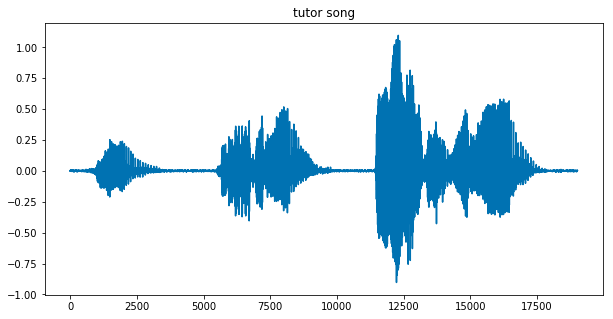

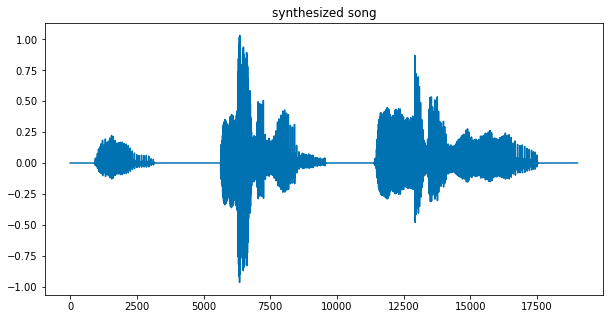

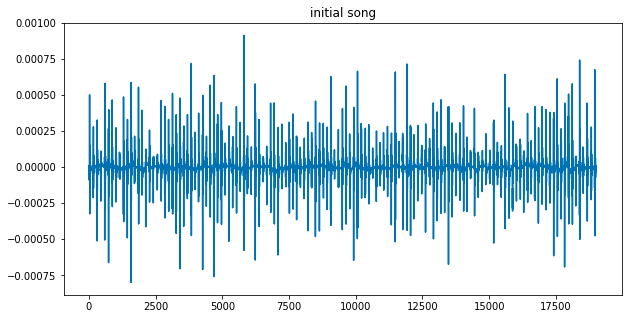

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(tutor)
plt.title("tutor song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(synth)
plt.title("synthesized song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(song)
plt.title("initial song")
plt.show()

# PB n°2
# plt.figure(figsize=(10, 5))
# plt.plot(synth_ab)
# plt.title("synthesized song from alpha beta")
# plt.show()

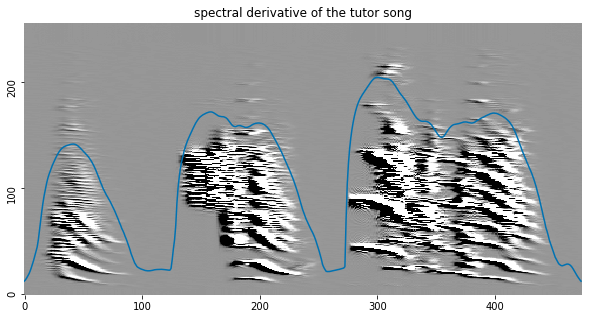

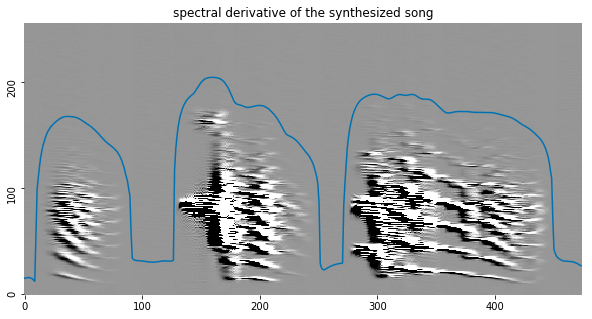

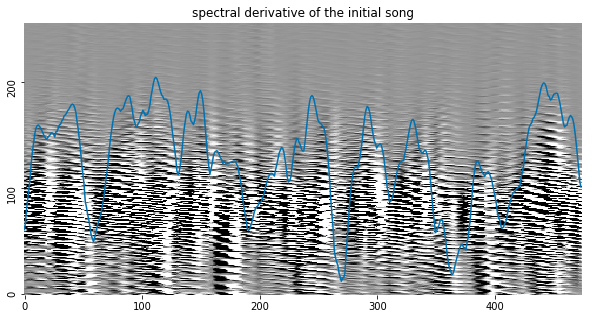

In [7]:
# Spectral derivatives
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
sspec = bsa.spectral_derivs(synth, 256, 40, 1024)
# initial song spectral derivative
ispec = bsa.spectral_derivs(song, 256, 40, 1024)

# PB n°2
# s_abspec = bsa.spectral_derivs(synth_ab, 256, 40, 1024)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(sspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the synthesized song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(ispec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the initial song")
plt.show(fig)

# PB n°2
# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()
# ax = bsa.spectral_derivs_plot(s_abspec, contrast=0.01, ax=ax)
# bsa.plot_over_spec(bsa.song_amplitude(synth_ab, 256, 40, 1024), ax=ax)
# plt.title("spectral derivative of the synthesized song from alpha beta")
# plt.show(fig)

Rq : On observe plus les effets de bord

# bsa_measure function step by step

# Features dict

In [8]:
tutor_feat = bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40)
synth_feat = bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40)
song_feat = bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40)

# Plots of features evolution during the song

In [9]:
fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude']

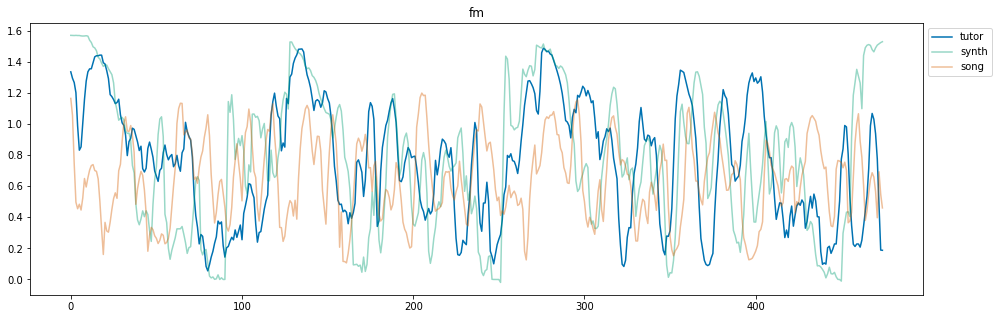

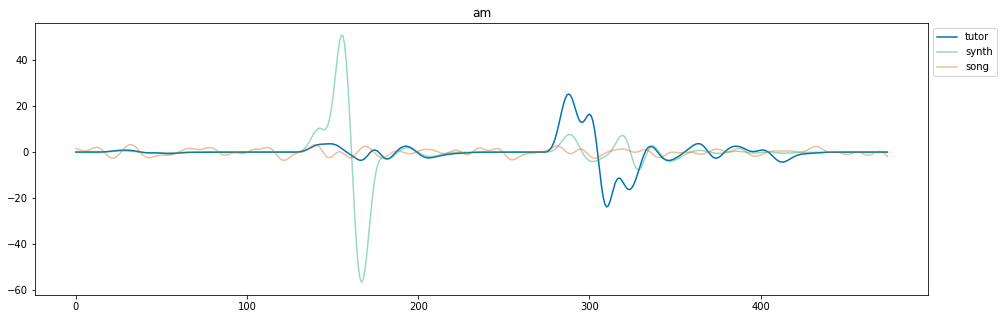

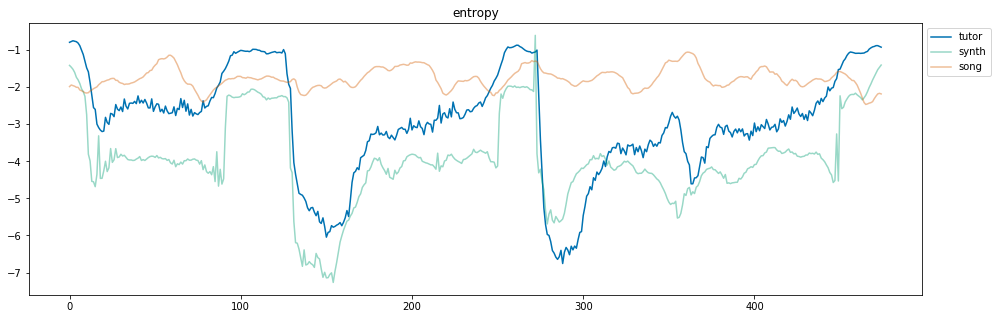

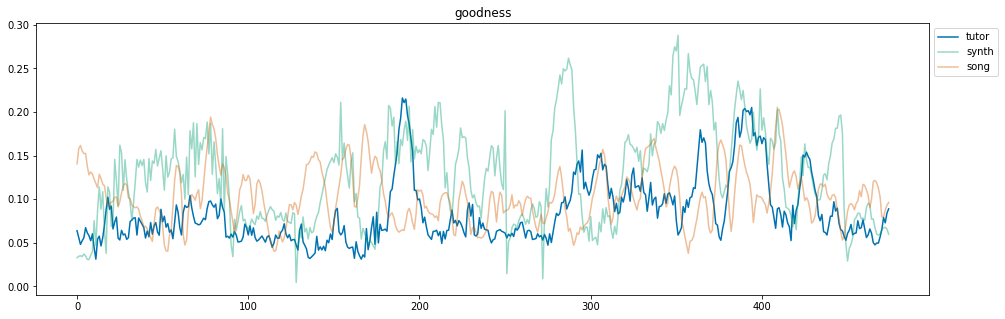

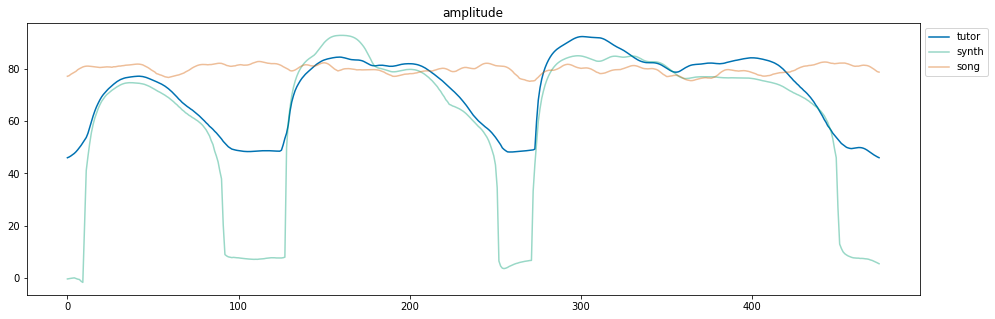

In [10]:
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

Rq :

tuteur : en normalisant + centralisant on retrouve les résultats inititaux du tuteur non normalisé

- am : pas de modifications quelque soit le signal

- synth : plus d'effets de bord
    - fm : donne des valeurs plus proches à certains endroit ==> amélioration
    - entropy : changement de valeur au niveau des silences, plus proche du tuteur
    - goodness : quelques pics vers 0
    - amplitude : les temps de silence tombent a des valeurs vraiment faibles (avant autour de 40, maintenant entre 0 et 10)



In [11]:
# min and max value for each features
for feat in fnames:
    print("***  {}  ***".format(feat))
    print("tutor: min = {}, max = {}".format(tutor_feat[feat].min(), tutor_feat[feat].max()))
    print("synth: min = {}, max = {}".format(synth_feat[feat].min(), synth_feat[feat].max()))
    print("song: min = {}, max = {}".format(song_feat[feat].min(), song_feat[feat].max()))
    print()

***  fm  ***
tutor: min = 0.05522675447364868, max = 1.4874213576439794
synth: min = -0.01918950179309957, max = 1.5702749867807522
song: min = 0.10654767776798377, max = 1.1988340115474927

***  am  ***
tutor: min = -23.852731727769473, max = 25.290986429314643
synth: min = -56.6706740576979, max = 50.76276012940229
song: min = -3.5589019483924225, max = 3.2827356588832894

***  entropy  ***
tutor: min = -6.7562606547259065, max = -0.748354357368683
synth: min = -7.266683789989807, max = -0.6023670518383462
song: min = -2.46600804498364, max = -1.0540998856722457

***  goodness  ***
tutor: min = 0.03126282576730688, max = 0.21619138579143715
synth: min = 0.004544348008693213, max = 0.28799772499971227
song: min = 0.03796634391899507, max = 0.20307550634715307

***  amplitude  ***
tutor: min = 45.993646397940054, max = 92.28743861186499
synth: min = -1.6513490134956843, max = 92.75055179957442
song: min = 75.20284972125044, max = 82.76798730357383



# Plots of features evolution during the song

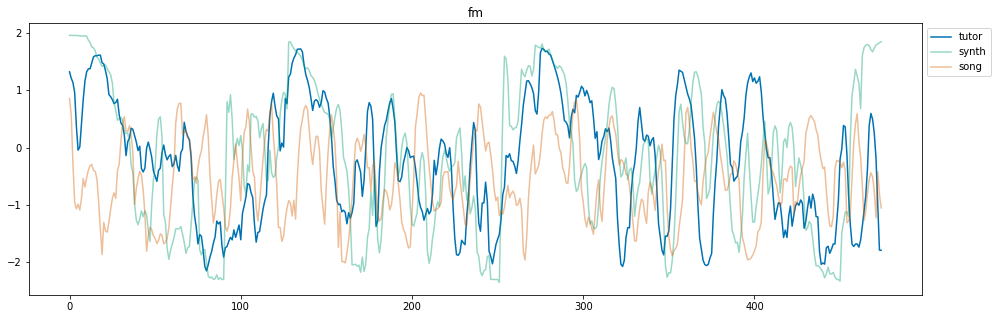

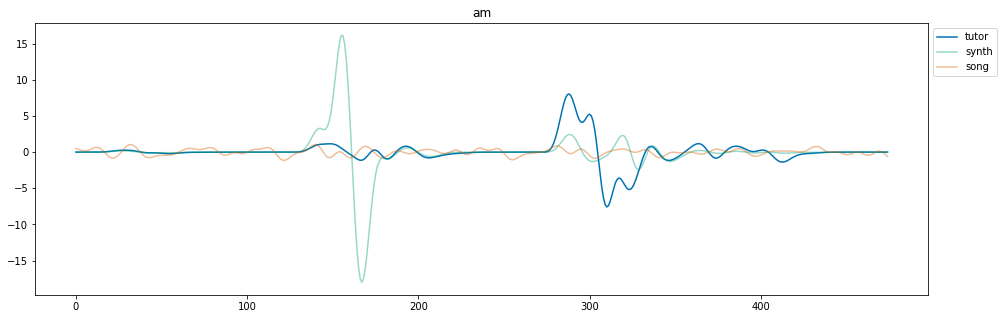

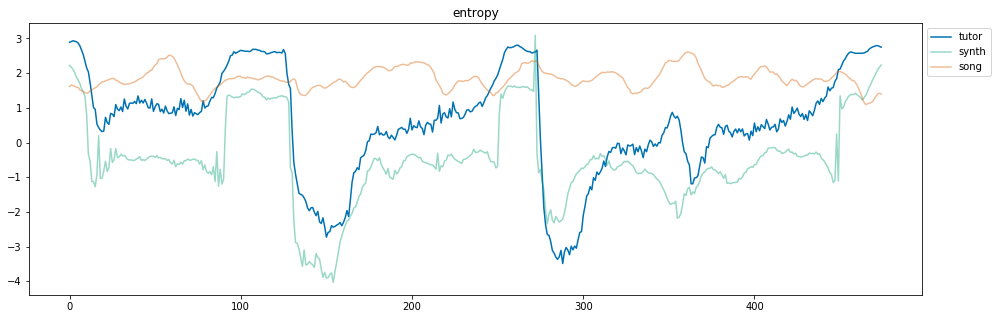

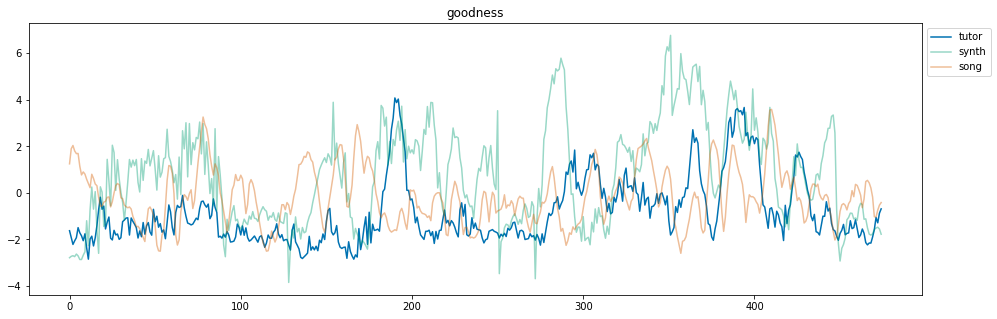

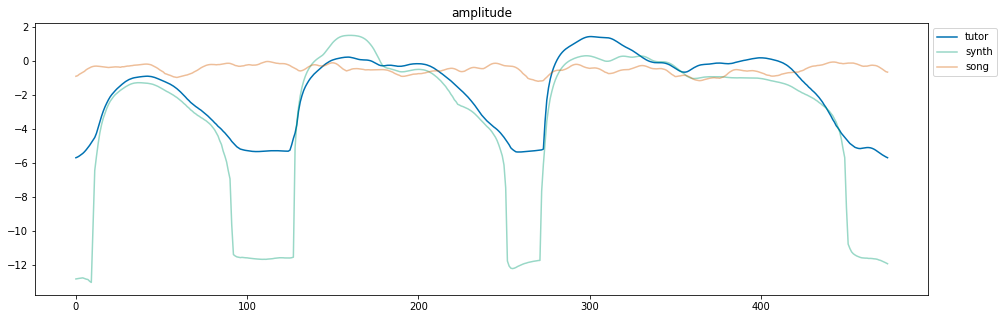

In [12]:
# MAD-NORMALIZED
tutor_feat = bsa.normalize_features(bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40))
synth_feat = bsa.normalize_features(bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40))
song_feat = bsa.normalize_features(bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40))
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

Rq : min de l'amplitude de synth est à -13 (-7 sans centralisation)

In [13]:
# min and max value for each features
for feat in fnames:
    print("***  {}  ***".format(feat))
    print("tutor: min = {}, max = {}".format(tutor_feat[feat].min(), tutor_feat[feat].max()))
    print("synht: min = {}, max = {}".format(synth_feat[feat].min(), synth_feat[feat].max()))
    print("song: min = {}, max = {}".format(song_feat[feat].min(), song_feat[feat].max()))
    print()

***  fm  ***
tutor: min = -2.155613881876132, max = 1.734878097017825
synht: min = -2.3577622822850035, max = 1.9599462398982188
song: min = -2.0162029107803994, max = 0.9509436004673253

***  am  ***
tutor: min = -7.587380043208721, max = 8.044618360941483
synht: min = -18.026354572753625, max = 16.146869081123263
song: min = -1.1321681336965699, max = 1.0440707055555882

***  entropy  ***
tutor: min = -3.4890126353310653, max = 2.9332730955750157
synht: min = -4.034640855227183, max = 3.089329489066594
song: min = 1.0971487915957385, max = 2.6064395787846393

***  goodness  ***
tutor: min = -2.8467375635244756, max = 4.078164149195935
synht: min = -3.8472473407474386, max = 6.767050286105688
song: min = -2.595715199408189, max = 3.587022185965886

***  amplitude  ***
tutor: min = -5.7048742919633755, max = 1.4396904952392262
synht: min = -13.05797154806982, max = 1.5111631920126556
song: min = -1.196990285364481, max = -0.029455438980631344



# Contribution of each feature (in a vector) in the error calculation

In [14]:
# mtutor and msong are results from bsa_measure()
def err_per_feat(mtutor, msong):
    err_feats = np.zeros(mtutor.shape[1])
    for i in range(mtutor.shape[1]):
        err_feats[i] = np.sum(np.absolute(mtutor[:,i] - msong[:,i])**2)
    return err_feats

def carac_to_calculate_err_of_synth(tutor_song, synth_song, p_coefs):
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    return amp, threshold

# calcul a faire apres l'appel de carac_to_calculate_err_of_synth
# err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
# score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)

In [15]:
coefs = {"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1}

mtutor = bsa_measure(tutor, sr, coefs)
msynth = bsa_measure(synth, sr, coefs)
msong = bsa_measure(song, sr, coefs)

# Own calculation
print("err for INIT song from err per feat:", math.sqrt(np.sum(err_per_feat(mtutor, msong))))
print("sum of err per feat == err squared:", np.sum(err_per_feat(mtutor, msong)))

amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
synth_score = math.sqrt(np.sum(err_per_feat_synth)) / np.sum(amp > threshold) * len(amp)

print("err for SYNTH song from err per feat:", synth_score)
print()

# Check with initial functions
song_err = error_measure(mtutor, msong)
print("Initial song error:", song_err)
print("Initial song error SQUARED:", song_err**2)

synth_err = boari_synth_song_error(tutor, synth, coefs)
print("Boari synth error:", synth_err)

err for INIT song from err per feat: 136.89053893048634
sum of err per feat == err squared: 18739.019648679
err for SYNTH song from err per feat: 139.94739146413704

Initial song error: 136.89053893048637
Initial song error SQUARED: 18739.019648679005
Boari synth error: 139.94739146413704


In [16]:
coefs_list = [{"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1},
              {"fm": 1, "am": 1, "entropy": 5, "goodness": 1, "amplitude": 5, "pitch": 1}]

# coefs_list = [{"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1}]

In [17]:
fnames = ["fm", "am", "entropy", "goodness", "amplitude"]

for coefs in coefs_list:
    print("fm: {} / am: {} / entropy: {} / goodness: {} / amplitude: {}"
          .format(coefs["fm"], coefs["am"], coefs["entropy"], coefs["goodness"], coefs["amplitude"]))
    
    mtutor = bsa_measure(tutor, sr, coefs)
    msynth = bsa_measure(synth, sr, coefs)
    msong = bsa_measure(song, sr, coefs)
    
    err_feat_vect = err_per_feat(mtutor, msong)
    amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
    err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
    
    synth_err = boari_synth_song_error(tutor, synth, coefs)
    song_err = error_measure(mtutor, msong)
    
    print("Boari err per feat:")
    str_synth = "synth: "
    str_song = "song: "
    for i in range(len(fnames)):
        str_synth += "\t{}: {}".format(fnames[i], round(err_per_feat_synth[i],3))
        str_song += "\t{}: {}".format(fnames[i], round(err_feat_vect[i],3))
    print(str_synth)
    print(str_song)
    print()
    print("Boari synth error:", synth_err)
    print("Initial song error:", song_err)
    print()
    print("Delta:", song_err - synth_err)
    print()

fm: 1 / am: 1 / entropy: 1 / goodness: 1 / amplitude: 1
Boari err per feat:
synth: 	fm: 431.328	am: 4884.151	entropy: 748.757	goodness: 2948.325	amplitude: 551.871
song: 	fm: 803.93	am: 1534.147	entropy: 1899.821	goodness: 1946.686	amplitude: 3258.672

Boari synth error: 139.94739146413704
Initial song error: 136.89053893048637

Delta: -3.0568525336506696

fm: 1 / am: 1 / entropy: 5 / goodness: 1 / amplitude: 5
Boari err per feat:
synth: 	fm: 431.328	am: 4884.151	entropy: 18718.936	goodness: 2948.325	amplitude: 13796.77
song: 	fm: 803.93	am: 1534.147	entropy: 47495.533	goodness: 1946.686	amplitude: 81466.794

Boari synth error: 256.22869014233333
Initial song error: 377.5484792454036

Delta: 121.31978910307026



Rq : l'erreur des features du synthé est plus faibles que si les signaux ne sonst pas centralisés ou normalisés. Cependant les features liées aux amplitudes sont moins bonnes ==> revoir le threshold pour ne considérer que les parties pertinentes.